In [ ]:
!pip install -U -q PyDrive ## you will have install for every colab session
 
from google.colab import drive
drive.mount('/content/drive')
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
 
dataset = drive.CreateFile({'id':'1jmHtnb0-_SPJvTVBs_CiiVf6kqRhXWmu'})
dataset.GetContentFile('dataset.zip')
!unzip dataset.zip

In [ ]:
import skimage
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
from skimage.color import rgb2gray
import scipy
import skimage.transform
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import time
from tqdm.notebook import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pickle
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from skimage.feature import hog

%matplotlib inline

# Feature extraction steps

In [ ]:
img = rgb2gray(io.imread('00_test_img_input/train/10911.png'))
img_size = 96
img = skimage.transform.resize(img, output_shape=(img_size, img_size), anti_aliasing=True)

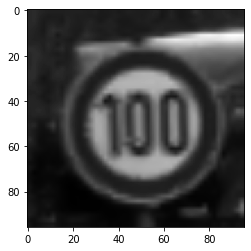

In [ ]:
plt.imshow(img, cmap='gray')
plt.show()

### 1. derivatives

In [ ]:
Dx = np.array([[-1, 0, 1]])
Dy = Dx.T

Ix = scipy.signal.convolve2d(img, Dx, boundary='symm', mode='same')
Iy = scipy.signal.convolve2d(img, Dy, boundary='symm', mode='same')

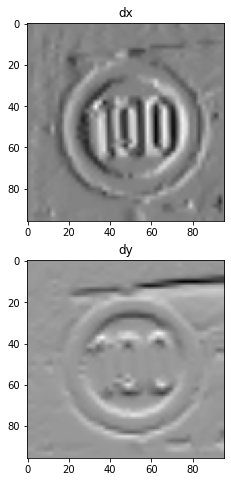

In [ ]:
fig, (ax_mag, ax_ang) = plt.subplots(2, 1, figsize=(4, 8))
ax_mag.imshow(Ix, cmap='gray')
ax_mag.set_title('dx')
ax_ang.imshow(Iy, cmap='gray')
ax_ang.set_title('dy')
fig.show()

### 2. gradient abs, angle

In [ ]:
grad_abs = np.sqrt(Ix**2 + Iy**2)

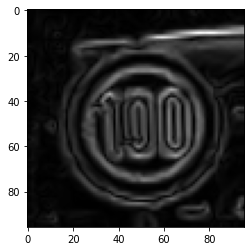

In [ ]:
plt.imshow(grad_abs, cmap='gray')
plt.show()

In [ ]:
grad_dir = np.arctan2(Iy, Ix)

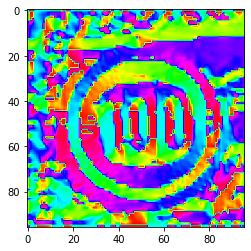

In [ ]:
plt.imshow(grad_dir, cmap='hsv')
plt.show()

### 3. unsigned gradient

In [ ]:
grad_dir[grad_dir < 0] = np.pi + grad_dir[grad_dir < 0]
grad_dir = np.clip(grad_dir, 0, np.pi)

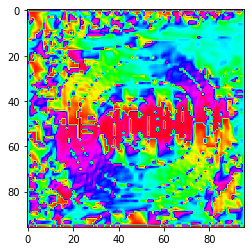

In [ ]:
plt.imshow(grad_dir, cmap='hsv')
plt.show()

### 4. cells & histograms

In [ ]:
cell_rows = 8
cell_cols = 8
bin_count = 9

In [ ]:
num_cells_row, num_cells_col = img_size // cell_rows, img_size // cell_cols
bins = np.linspace(0, np.pi, bin_count + 1)
cell_descriptors = np.empty((num_cells_row, num_cells_col, bin_count), dtype=np.float64)

for i in range(bin_count):
    in_bin = (grad_dir >= bins[i]) * (grad_dir <= bins[i + 1]) * grad_abs
    cell_descriptors[:, :, i] = np.sum(in_bin.reshape(num_cells_row, cell_rows, -1, cell_cols).swapaxes(1, 2).reshape(num_cells_row, num_cells_col, -1), axis=-1)

# for i in range(num_cells_row):
#     for j in range(num_cells_col):
#         cell_grad_dir = grad_dir[i * cell_rows: (i + 1) * cell_rows, j * cell_cols: (j + 1) * cell_cols]
#         cell_grad_abs = grad_abs[i * cell_rows: (i + 1) * cell_rows, j * cell_cols: (j + 1) * cell_cols]
        
#         hist, _ = np.histogram(cell_grad_dir, bins=bins, weights=cell_grad_abs)
#         cell_descriptors[i, j] = hist

### 5. blocks

In [ ]:
block_descriptors = []
eps = 1e-8

for i in range(num_cells_row - 1):
    for j in range(num_cells_col - 1):
        block_vec = cell_descriptors[i: i + 2, j: j + 2].flatten()
        block_vec = block_vec / np.sqrt(np.linalg.norm(block_vec) + eps)
        block_descriptors.append(block_vec)
        
hog_descriptor = np.concatenate(block_descriptors)

# Final

### functions

In [ ]:
def extract_hog(image_path, img_size, hist_params, block_params):
    img = rgb2gray(io.imread(image_path))
    #img = img[int(0.1 * img.shape[0]): int(0.9 * img.shape[0]), int(0.1 * img.shape[1]): int(0.9 * img.shape[1])]
    img = skimage.transform.resize(img, output_shape=(img_size, img_size))

    Dx = np.array([[-1, 0, 1]])
    Dy = Dx.T

    Ix = scipy.signal.convolve2d(img, Dx, boundary='symm', mode='same')
    Iy = scipy.signal.convolve2d(img, Dy, boundary='symm', mode='same')

    grad_abs = np.sqrt(Ix**2 + Iy**2)
    grad_dir = np.arctan2(Iy, Ix)

    # grad_dir[grad_dir < 0] = np.pi + grad_dir[grad_dir < 0]
    # grad_dir = np.clip(grad_dir, 0, np.pi)

    del Ix
    del Iy
    del img

    cell_rows, cell_cols, bin_count = hist_params

    num_cells_row, num_cells_col = img_size // cell_rows, img_size // cell_cols
    bins = np.linspace(-np.pi, np.pi, bin_count + 1)
    cell_descriptors = np.empty((num_cells_row, num_cells_col, bin_count), dtype='float64')

    for i in range(bin_count):
        in_bin = (grad_dir >= bins[i]) * (grad_dir <= bins[i + 1]) * grad_abs
        cell_descriptors[:, :, i] = np.sum(in_bin.reshape(num_cells_row, cell_rows, -1, cell_cols).swapaxes(1, 2).reshape(num_cells_row, num_cells_col, -1), axis=-1)

    del grad_dir
    del grad_abs

    block_descriptors = []
    eps = 1e-3
    spanx, spany = block_params

    for i in range(num_cells_row - spanx + 1):
        for j in range(num_cells_col - spany + 1):
            block_vec = cell_descriptors[i: i + spanx, j: j + spany].flatten()
            block_vec = block_vec / np.sqrt(np.linalg.norm(block_vec) + eps)
            block_descriptors.append(block_vec)

    hog_descriptor = np.concatenate(block_descriptors)

    return hog_descriptor

In [ ]:
def skimage_hog(image_path, img_size, hist_params, block_params):
    img = rgb2gray(io.imread(image_path))
    img = skimage.transform.resize(img, output_shape=(img_size, img_size))
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    return fd

In [ ]:
skimage_hog('00_test_img_input/train/10911.png', 96, None, None).shape

(288,)

In [ ]:
# @profile
def get_datasets(img_size, hist_params, block_params):
    base_dir = ''
    labels_path = base_dir + '00_test_img_input/train/gt.csv'
    image_dir = base_dir + '00_test_img_input/train/'

    labels = pd.read_csv(labels_path)
    labels.head()

    num_classes = labels.class_id.nunique()
    images_train, images_test, y_train, y_test = [], [], [], []

    for cls_ind in tqdm(range(num_classes)):
        temp_df = labels.loc[labels.class_id == cls_ind]
        num_phys_objects = temp_df.phys_id.nunique()
        objects_train, objects_test = train_test_split(np.arange(num_phys_objects, dtype=int), test_size=0.33, shuffle=True)
        for row_ind in range(len(temp_df)):
            temp_row = temp_df.iloc[row_ind]
            if temp_row['phys_id'] in objects_train:
                images_train.append(temp_row['filenames'])
                y_train.append(cls_ind)
            elif temp_row['phys_id'] in objects_test:
                images_test.append(temp_row['filenames'])
                y_test.append(cls_ind)
            else:
                raise Exception('unknown object')
    
    start_time = time.time()

    X_train, X_test = [], []

    for filename in tqdm(images_train):
        X_train.append(skimage_hog(image_dir + filename, img_size, hist_params, block_params))

    for filename in tqdm(images_test):
        X_test.append(skimage_hog(image_dir + filename, img_size, hist_params, block_params))

    perm = np.random.permutation(len(X_train))
    X_train = np.asarray(X_train)[perm]
    y_train = np.asarray(y_train)[perm]

    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)

    print('Feature extraction time: ', time.time() - start_time)
    return X_train, X_test, y_train, y_test

In [ ]:
# @profile
def train_and_predict(model, model_name, datasets):
    start_time = time.time()
    X_train, X_test, y_train, y_test = datasets
    clf = model
    clf.fit(X_train, y_train)
    print('Training time: ', time.time() - start_time)

    start_time = time.time()
    y_pred = clf.predict(X_test)
    print('Prediction time: ', time.time() - start_time)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
 
    pickle.dump(clf, open('drive/My Drive/CV/%s.pkl' % model_name, 'wb'))

### experiments

In [ ]:
X_train, X_test, y_train, y_test = get_datasets(img_size=96, hist_params=(8, 8, 9), block_params=(2, 2))


Feature extraction time:  766.0004391670227


In [ ]:
X_train.shape

(25710, 288)

In [ ]:
model = SGDClassifier(loss='hinge', penalty='l2', alpha=1, learning_rate='adaptive', eta0=0.0003, max_iter=10000)
train_and_predict(model, 'linear_sgd', (X_train, X_test, y_train, y_test))

Training time:  23.047332048416138
Prediction time:  0.02792954444885254
Accuracy:  0.68634713682495


In [ ]:
svd = TruncatedSVD(n_components=2000)
svd.fit(X_train)
X_train = svd.transform(X_train)
X_test = svd.transform(X_test)

In [ ]:
model_svd = LinearSVC(C=1, multi_class='crammer_singer', dual=False, max_iter=10000)
train_and_predict(model_svd, 'linear_svc', (X_train, X_test, y_train, y_test))

Training time:  202.01078391075134
Prediction time:  0.030928611755371094
Accuracy:  0.8207407407407408


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
model_svd = LinearSVC(max_iter=10000)
train_and_predict(model_svd, 'linear_svc', (X_train, X_test, y_train, y_test))

Training time:  82.0715537071228
Prediction time:  0.17473793029785156
Accuracy:  0.9408888888888889


In [ ]:
import pickle

pickle.dump((X_train, X_test, y_train, y_test), open('drive/My Drive/CV/data_6_6.pkl', 'wb'))
#(X_train, X_test, y_train, y_test) = pickle.load(open('drive/My Drive/CV/data.pkl', 'rb'))

In [ ]:
import pickle

# pickle.dump((X_train, X_test, y_train, y_test), open('drive/My Drive/CV/data.pkl', 'wb'))
(X_train, X_test, y_train, y_test) = pickle.load(open('drive/My Drive/CV/data.pkl', 'rb'))